<a href="https://colab.research.google.com/github/sanvir/my_source_2/blob/main/My_source_3_21_04_2022_Copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.mql5.com/ru/articles/9514
# https://cran.r-project.org/web/packages/PSF/vignettes/PSF_vignette.html
# https://habr.com/ru/post/562092/
# https://www.mql5.com/ru/blogs/post/746398
# ии прогноз свечей пример colab
#

In [ ]:
# !!! Обязательно загрузить сначала это !!!
file_name = "2022-04-22"

In [ ]:
# Загружаем исходные данные, извлекаем нужные, создаём модель, обучаем и сохраняем её в файл

from os import rename # 
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow as tf



# Загружаем котировки из файла

#file_name = "2022-04-21"
file_ext = ".txt"  # расширение

#students_performance = pd.read_csv('./EURUSD_M1_202201102215_202204181408.csv', sep='\t') # Загрузка файла с сайта
My_NeuralNetwork = pd.read_csv(file_name+file_ext, sep=',', 
                               encoding='windows-1251', names=["Номер", "Время", "Инструмент", "Рынок", "nul_2","Цена", "nul_3","Количество",
                                                               "Объем","nul_6","nul_7","nul_8","nul_9","nul_10","nul_11","Операция"], index_col='Номер') # Загрузка файла с сайта
                                                                                                                              # , parse_dates=["Время"]
# Выборка данных:          
My_NeuralNetwork = My_NeuralNetwork[['Время', 'Цена', 'Количество', 'Операция']] # Если нужно вывести несколько столбцов, в квадратные скобки нужно вставить список с их названиями
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Количество'] > 300]  # Оставить строки, где значение дольше 300

#My_NeuralNetwork.drop_duplicates(subset=['Время'], keep=False)

# 'Операция' Заменяем S на 0, а B на 1
My_NeuralNetwork['Операция'] = [x.replace("S", "0") for x in My_NeuralNetwork['Операция']] # Заменяем S на 0
My_NeuralNetwork['Операция'] = [x.replace("B", "1") for x in My_NeuralNetwork['Операция']] # Заменяем B на 1


# Будущее_Вектор_в_пунктах
My_NeuralNetwork['Будущее_Вектор_в_пунктах'] = (My_NeuralNetwork['Цена'] - (My_NeuralNetwork['Цена'].shift(-1,fill_value=0))) # цену акций предыдущего дня .shift(-1,fill_value=0) в виде нового столбца
My_NeuralNetwork.loc[My_NeuralNetwork['Операция'] == '1', 'Будущее_Вектор_в_пунктах'] = (My_NeuralNetwork['Будущее_Вектор_в_пунктах']*-1) # Если число отрицательное, значит цена двинулась вниз = 0

# Будущее_Вектор
My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] < 0, 'Будущее_Вектор'] = 0          # Если число отрицательное, значит цена двинулась вниз = 0
My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] > 0, 'Будущее_Вектор'] = 1          # Если число положительное, значит цена двинулась вверх = 1

#Удаляю строки с Nan , 0, 1000 и -1000
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] !=0 ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор'] !='NaN' ]  # Оставить строки, где значение
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Вектор_предыдущий'] !='NaN' ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] <1000 ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] >-1000 ]  # Оставить строки, где значение

#Вектор_предыдущий
My_NeuralNetwork['Вектор_предыдущий'] = (My_NeuralNetwork['Будущее_Вектор'].shift(1,fill_value=0)) # Вектор_результат .shift(1,fill_value=0) в виде нового столбца

# В ПЕРВОЙ СТРОКЕ ОШИБКА В СТОЛБЦЕ "Вектор_предыдущий" ТАК КАК ПРЕДЫДУЩЕГО ВЕКТОРА В ПРИНЦИПЕ БЫТЬ НЕ МОЖЕТ
#My_NeuralNetwork.drop(My_NeuralNetwork.index[0], axis= 0)
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Номер'] !=aaa ]  # Оставить строки, где значение

# Меняю тип данных чтобы избавиться от стринга и флоата 
My_NeuralNetwork = My_NeuralNetwork.astype({'Операция': np.int8})
My_NeuralNetwork = My_NeuralNetwork.astype({'Будущее_Вектор': np.int8})
My_NeuralNetwork = My_NeuralNetwork.astype({'Вектор_предыдущий': np.int8})

df=My_NeuralNetwork
df.to_excel(file_name+".xlsx", sheet_name='Sheet_name_1') # Сохраняю в файл

#df.head(5)
#My_NeuralNetwork
#My_NeuralNetwork.sample() # 6 случайных записей

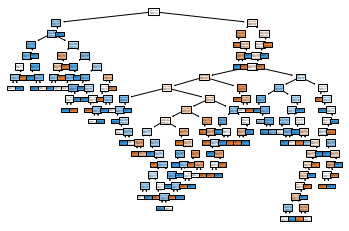

In [ ]:
# создаём модель, обучаем и сохраняем её в файл
# Решающие деревья
from sklearn import tree # Решающие деревья
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = df
# Создаём датафрейм с данными
#data = pd.DataFrame({'X_1': [1, 1, 1, 0, 0, 0, 0, 1], 'X_2': [0, 0, 0, 1, 0, 0, 0, 1], 'Y': [1, 1, 1, 1, 0, 0, 0, 0]})
#data

# Разновидности вариантов генерации решений
#model = tree.DecisionTreeClassifier()
model = tree.DecisionTreeClassifier(criterion='entropy')
#model = LogisticRegression()

X = data[['Количество', 'Операция','Вектор_предыдущий',]]
y = data.Будущее_Вектор
model.fit(X,y) # наше дерево - Обучилось(fit)

# Сохраняем модель в файл
import pickle
filename = 'Saved_model/tree-'+file_name+'.model'  # file_name - оно объявлено в начале юпитера
pickle.dump(model, open(filename, 'wb'))

# Рисуем Блок-схему дерева решений, вариант 2
from sklearn.tree import plot_tree
plot_tree(model,filled=True); 

# !!!! Жди пока нарисуется схема

In [ ]:
# Создаю прогноз и сохраняю в файл
# Подаю на вход параметры и получаю предсказания (В виде DataFrame)
df['Предсказания']=model.predict(df[['Количество', 'Операция','Вектор_предыдущий',]])
#dd = data[['Количество', 'Операция','Вектор_предыдущий','Будущее_Вектор','Предсказания']]
#dd = My_NeuralNetwork[['Время', 'Цена', 'Количество', 'Операция','Вектор_предыдущий','Будущее_Вектор','Предсказания']]

df.to_excel(file_name+"_predict.xlsx", sheet_name="Sheet_name_1") # Сохраняю DataFrame в xlsx файл 
# file_name - оно объявлено в начале юпитера

In [ ]:
# Предсказания
# Подаю на вход параметры и получаю предсказания (В виде DataFrame)
df['Предсказания']=model.predict(df[['Количество', 'Операция','Вектор_предыдущий',]])

#data_frame = df.where(data_frame < 0, 0)
df['+'] = df['Будущее_Вектор_в_пунктах']
df.loc[df['Будущее_Вектор_в_пунктах'] < 0, '+'] = df['Будущее_Вектор_в_пунктах']*-1

df.loc[df['Будущее_Вектор'] == df['Предсказания'], 'Сбылось'] = df['+']
df.loc[df['Будущее_Вектор'] != df['Предсказания'], 'Сбылось'] = df['+']*-1


df.loc[df['Будущее_Вектор'] != df['Предсказания'], 'Не_сбылось'] = df['+']
df.loc[df['Будущее_Вектор'] == df['Предсказания'], 'Не_сбылось'] = df['+']*-1

# Сохраняю DataFrame в xlsx файл 
df.to_excel(file_name+"_predict.xlsx", sheet_name="Sheet_name_1") 
# file_name - оно объявлено в начале юпитера

Total1 = df['Сбылось'].sum()
print ("Сбылось sum:",Total1)

Total2 = df['Не_сбылось'].sum()
print ("Не_сбылось sum:",Total2)

#

Сбылось sum: 29.0
Не_сбылось sum: -29.0


In [ ]:
df.head()

,Время,Цена,Количество,Операция,Будущее_Вектор_в_пунктах,Будущее_Вектор,Вектор_предыдущий,Предсказания,+,Сбылось,Не сбылось
Номер,,,,,,,,,,,
1892947264515607227,10:00:33,77659,110,1,123,1,0,1,123,123.0,-123.0
1892947264515607399,10:00:35,77782,116,0,51,1,1,1,51,51.0,-51.0
1892947264515607679,10:00:43,77731,109,0,28,1,1,0,28,-28.0,28.0
1892947264515608571,10:00:58,77703,120,0,-72,0,1,0,72,72.0,-72.0
1892947264515609133,10:01:12,77775,107,1,25,1,0,0,25,-25.0,25.0


In [ ]:
# Загружаем модель из файла
import pickle
#file_name = "2022-04-21"
filename = 'Saved_model/tree-'+file_name+'.model'  # file_name - оно объявлено в начале юпитера
model = pickle.load(open(filename, 'rb'))
#result = model.score(X_test, Y_test)
#print(result)

# Рисуем Блок-схему дерева решений, вариант 2
from sklearn.tree import plot_tree
plot_tree(model,filled=True); 

# !!!! Жди пока нарисуется схема

FileNotFoundError: [Errno 2] No such file or directory: 'Saved_model/tree-2022-04-19.model'

In [ ]:
# Подаю на вход параметры и получаю предсказания
print(model.predict([[189, 1,0]]))

[1]
